# V2.0 星冕仪可见光相机仿真

Cpic仿真程序中的emccd仿真模块对系统中的EMCCD进行仿真，包括暗电流、非均匀性、非线性、增益、电子倍增等效应。

CpicVisEmccd类为emccd仿真模块的主类，包含了EMCCD的各种参数，以及对应的仿真函数。

In [1]:
%reload_ext autoreload
%autoreload 2


import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from csst_cpic_sim.camera import CpicVisEmccd
from csst_cpic_sim.utils import psf_imshow

EMCCD类在初始化时，根据config.py 或者 config.yaml 中的内容，读取暗场、平场、CIC场的fits文件，并设置为类的属性。
下面几幅图为默认的参考图像。

Text(0.5, 1.0, 'CIC')

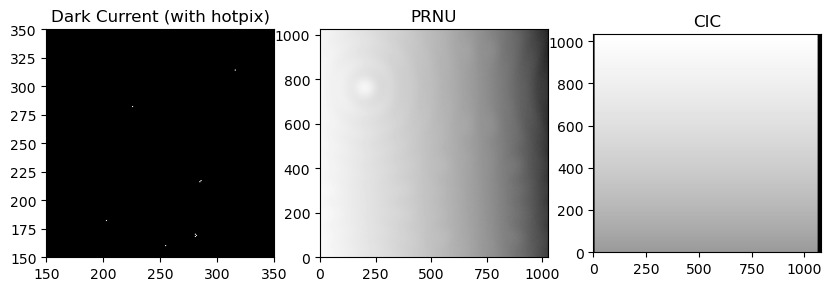

In [2]:
emccd = CpicVisEmccd()

f, ax = plt.subplots(3, 1, figsize=(10, 4))
plt.subplot(1, 3, 1)
psf_imshow(emccd.dark, vmin=1e-8, vmax=1)
plt.xlim([150, 350])
plt.ylim([150, 350])
plt.title('Dark Current (with hotpix)')
plt.subplot(1, 3, 2)
psf_imshow(emccd.flat, vmin=1e-8, vmax=1)
plt.title('PRNU')
plt.subplot(1, 3, 3)
psf_imshow(emccd.cic, vmin=0, vmax=1)
plt.title('CIC')

## 本底测试
本底上具有横条纹、竖条纹、本底波动，噪点等特性。另外当设置em倍增后，本底回随着EM增益的变化存在漂移现象。

Text(0, 206, 'bias images have a $\\sigma$ = 3 DN variance\ncontroled by `emccd.bias_level_std`')

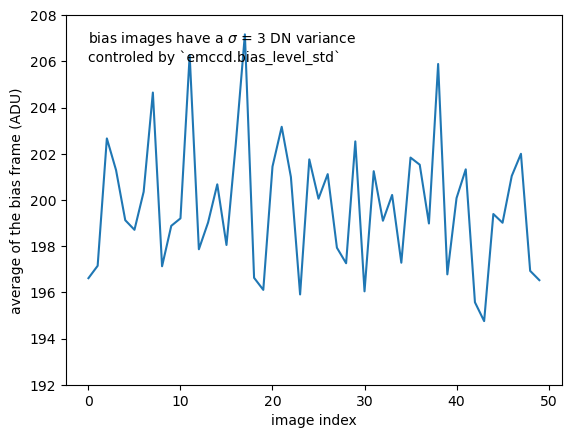

In [2]:
emccd = CpicVisEmccd()
blank = np.zeros(emccd.flat_shape)

bias = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias.fits', bias, overwrite=True)

emccd.switch['bias_vp'] = False
bias_no_vp = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novp.fits', bias_no_vp, overwrite=True)

emccd.switch['bias_hp'] = False
bias_no_vphp = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novphp.fits', bias_no_vphp, overwrite=True)

emccd.switch['bias_ci'] = False
bias_no_vphpci = emccd.readout(blank, 1023, 0)
fits.writeto('image_files/_test_bias_novphpci.fits', bias_no_vphpci, overwrite=True)

bias_level = []
for i in range(50):
    imgout = emccd.readout(blank, 1023, 0)
    bias_level.append(imgout.mean())

plt.plot(bias_level)
plt.ylim([192, 208])
plt.xlabel('image index')
plt.ylabel('average of the bias frame (ADU)')
plt.text(0, 206, f"bias images have a $\sigma$ = {emccd.bias_level_std} DN variance\ncontroled by `emccd.bias_level_std`")

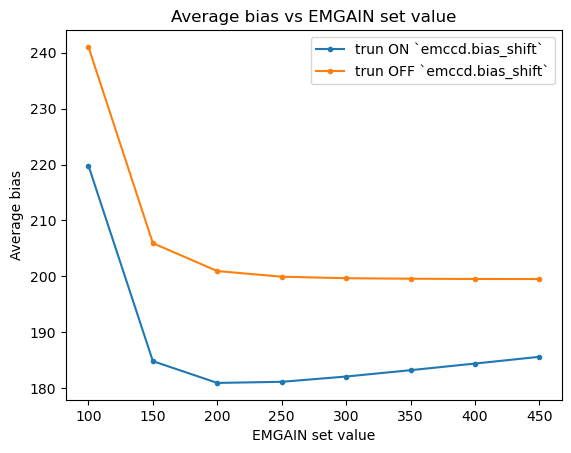

In [3]:
emccd = CpicVisEmccd()
emset_values = list(range(100, 500, 50))
emccd.time_syn(0, initial=True)
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.bias_level_std = 0
emccd.cic = 0.2

emccd.switch['bias_shift'] = True
bias_average = []
for emset in emset_values:
    bias = emccd.readout(blank, emset, 0)
    avg_bias = np.mean(bias)
    bias_average.append(avg_bias)

plt.plot(emset_values, bias_average, '.-', label='trun ON `emccd.bias_shift`')

emccd.switch['bias_shift'] = False
bias_average = []
for emset in emset_values:
    biases = []
    bias = emccd.readout(blank, emset, 0)
    avg_bias = np.mean(bias)
    bias_average.append(avg_bias)

plt.plot(emset_values, bias_average, '.-', label='trun OFF `emccd.bias_shift`')

plt.xlabel('EMGAIN set value')
plt.ylabel('Average bias')
plt.title('Average bias vs EMGAIN set value')
plt.legend()

## 测试倍增功能
电子倍增是EMCCD的特性之一。在星冕仪仪器相机中，通过改变EM寄存器的电压，控制放大倍率。

!WARNING!: More than 2000 (267471) pixels are saturated during EM process! [camera.py - emregester_blooming (line: 740)]: 


Text(0, 0.5, 'Flat image ADU')

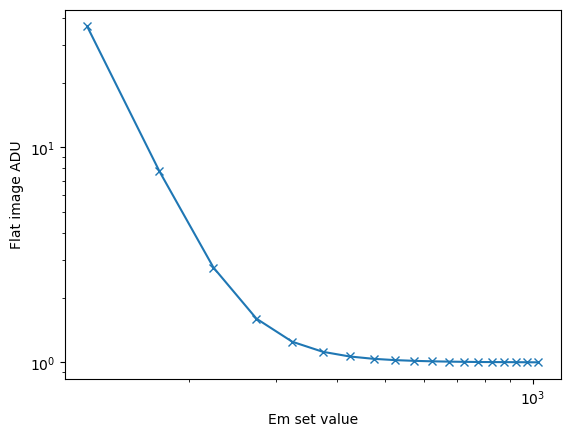

In [33]:
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False

flat_input = np.ones(emccd.flat_shape) * 100
emset_values = list(range(1024, 100, -50))
flat_values = []
for emset in emset_values:
    output = emccd.readout(flat_input, emset, 1)
    flat_values.append(output.mean())

flat_values = np.array(flat_values)
flat_values = flat_values / flat_values.min()

plt.semilogy(emset_values, flat_values, '-x')
plt.xlabel('Em set value')
plt.ylabel('Flat image ADU')

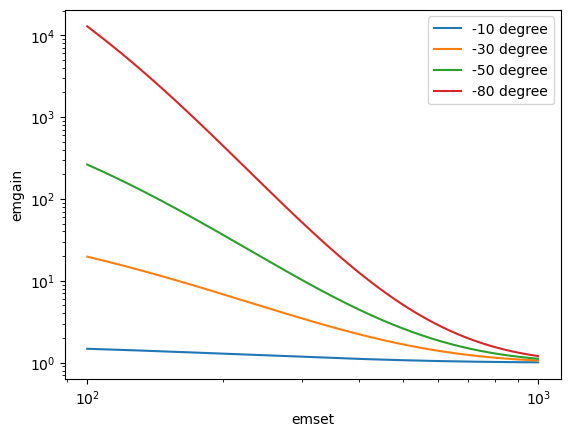

In [41]:
emset = np.arange(100, 1000)
for temp in [-10, -30, -50, -80]:
    emgain = emccd.emgain_set(emset, ccd_temp=temp, self_update=False)
    plt.loglog(emset, emgain, label=f'{temp} degree')

plt.xlabel('emset')
plt.ylabel('emgain')

plt.legend()

当存在EM倍增时，本底图像回具有不同的分布特征。利用该特征，可以进行EM增益和转换增益的标定。

201.2087824609938


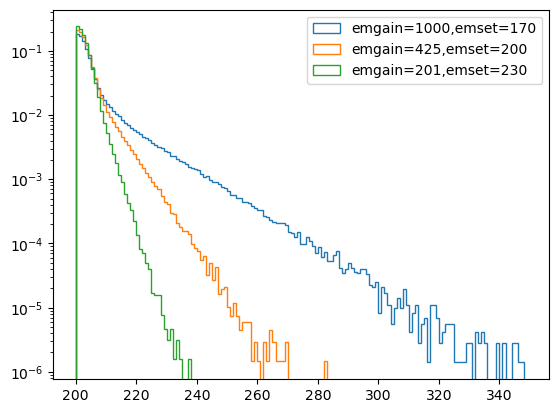

In [5]:

emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False

blank = np.zeros(emccd.flat_shape)

emset = 170
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')

emset = 200
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')

emset = 230
img = emccd.readout(blank, emset, 0)
out = plt.hist(img.flatten(), 
    bins = np.arange(200, 350),
    log=True,
    histtype='step',
    density=True,
    label=f'emgain={emccd.emgain:.0f},emset={emset}')
print(emccd.emgain)

plt.legend()

EM放大时，存在噪声系数这一概念。和传统ccd相比，EMCCD的具有更大散粒噪声。

Text(0, 0.5, 'noise [e-]')

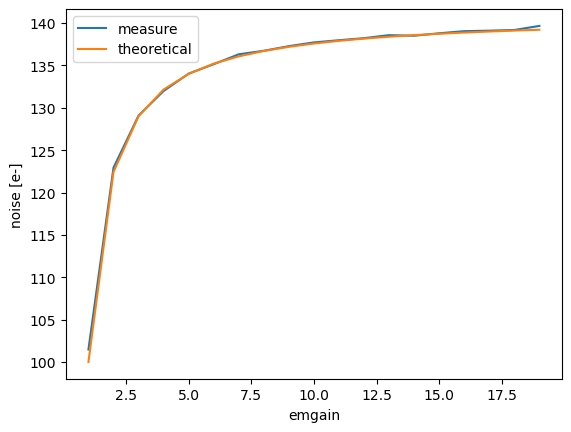

In [47]:
emccd = CpicVisEmccd()
emccd.time_syn(0, initial=True)
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False 
emccd.switch['badcolumn'] = False
emccd.switch['nonlinear'] = False
emccd.switch['flat'] = False
emccd.bias_level_std = 0
emccd.cic = 0.0
emccd.em_cte = 1
emccd.readout_noise = 0
emccd.max_adu = 1e100
emccd.em_fullwell = 1e100
emccd.emreg_cal_num = 100

flat_photon = 10000
flat = np.zeros(emccd.flat_shape) + flat_photon
emgains = []
all_img = []

for emgain in range(1, 20, 1):
    # print(emset)
    img = emccd.readout(flat, emgain, 1, emgain=emgain)
    emgains.append(emgain)
    all_img.append(img)

all_img_ph = (all_img[:, 100:-100, 100:-100].astype(float) - emccd.bias_level) * emccd.ph_per_adu * 1.0
for i, em in enumerate(emgains):
    all_img_ph[i, :, :] = all_img_ph[i, :, :] / em
noise = all_img_ph.std(axis=(1, 2))
mean = all_img_ph.mean(axis=(1, 2))

plt.plot(emgains, noise, label='measure')
N_REG = 604
F2 = 1 / emgains + 2 * (emgains - 1) * emgains ** (-(N_REG + 1) / N_REG)
plt.plot(emgains, np.sqrt(flat_photon * F2), label='theoretical')
plt.legend()
plt.xlabel('emgain')
plt.ylabel('noise [e-]')


EM增益和电压的关系收到温度的影响，在连续曝光时可能存在温度值的变化，从而导致EM倍增的变化。

In [28]:
blank = np.zeros(emccd.flat_shape) + 100
emccd.time_syn(0, initial=True)
times = []
temps = []
imgs = []
emgains = []
for i in range(100):
    img = emccd.readout(blank, 250, 0)
    emgains.append(emccd.emgain)
    imgs.append(img)
    times.append(emccd.system_time)
    temps.append(emccd.ccd_temp)

(0.0, 35.0)

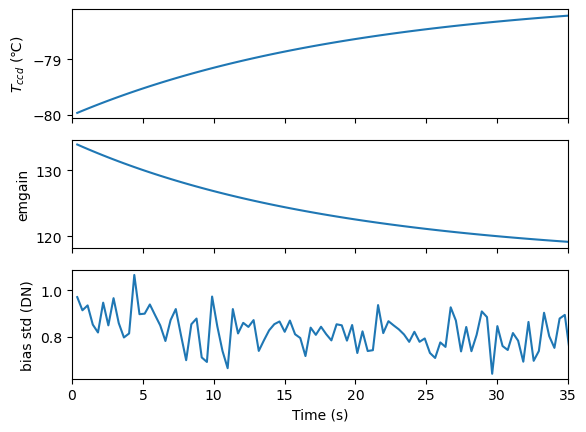

In [29]:
imgs = np.array(imgs)
stds = imgs[:, 100::-100, 100:-100].std(axis=(1, 2))

f, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(times, temps)
ax[0].set_ylabel(r'$T_{ccd}$ (℃)')
ax[1].plot(times, emgains)
ax[1].set_ylabel('emgain')
ax[2].plot(times, stds)

ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('bias std (DN)')
ax[2].set_xlim([0, 35])

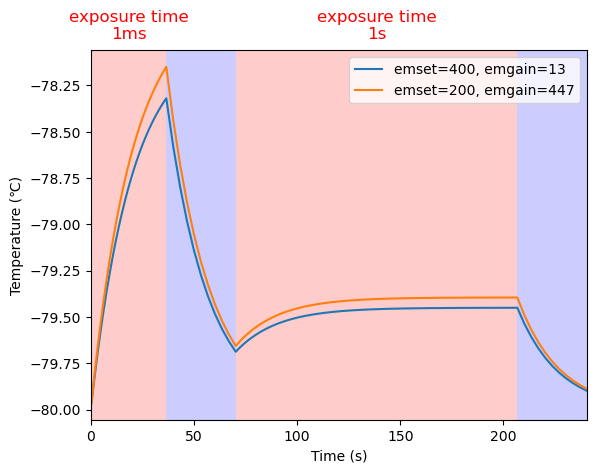

In [5]:
for emset in [400, 200]:

    emccd.time_syn(0, initial=True)
    emccd.emgain_set(emset)

    times = []
    temps = []
    imgs = []
    emgains = []
    def capture_n_frame(n, expt, reading=True):
        for _ in range(n):
            emccd.time_syn(expt + emccd.readout_time, readout=reading)
            temps.append(emccd.ccd_temp)
            times.append(emccd.system_time)
            emgains.append(emccd.emgain)
        return times[-1]

    
    t1 = capture_n_frame(100, 0.001, reading=True)
    t2 = capture_n_frame(10, 3, reading=False)
    t3 = capture_n_frame(100, 1, reading=True)
    t4 = capture_n_frame(10, 3, reading=False)

    plt.plot(times, temps, label=f'emset={emccd.emset}, emgain={np.mean(emgains):.0f}')

plt.xlabel('Time (s)')
plt.ylabel('Temperature (℃)')

t0 = 0
#画四块背景区域，用红蓝背景颜色，区分4个范围,四个区域的分割点分别是t0 - t4
plt.axvspan(t0, t1, color='r', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t1, t2, color='b', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t2, t3, color='r', edgecolor=None, alpha=0.2, linewidth=0)
plt.axvspan(t3, t4, color='b', edgecolor=None, alpha=0.2, linewidth=0)
plt.xlim([0, t4])

#两个红色的区域标上曝光时间1ms和曝光时间1s,text的位置使用相对图片的定位方式
plt.text((t0 + t1)/2, -78, 'exposure time\n1ms', fontsize=12, color='r', ha='center')
plt.text((t2 + t3)/2, -78, 'exposure time\n1s', fontsize=12, color='r', ha='center')
plt.legend()


在EM倍增过程中，回产生由于转移不充分导致的拖尾现象。

In [18]:
emccd = CpicVisEmccd()
emccd.switch['bias_vp'] = False
emccd.switch['bias_hp'] = False
emccd.switch['bias_ci'] = False
emccd.switch['bias_shift'] = False
emccd.bias_level_std = 0
emccd.readout_noise = 0
emccd.em_cte = 0.9996
emccd.emreg_cal_num = 10
emccd.cic = 0

pinhole = np.zeros(emccd.flat_shape)
pinhole[512, 512] = 10000
cici = emccd.readout(pinhole, 1024, 1)
fits.writeto('_cic.fits', cici, overwrite=True)

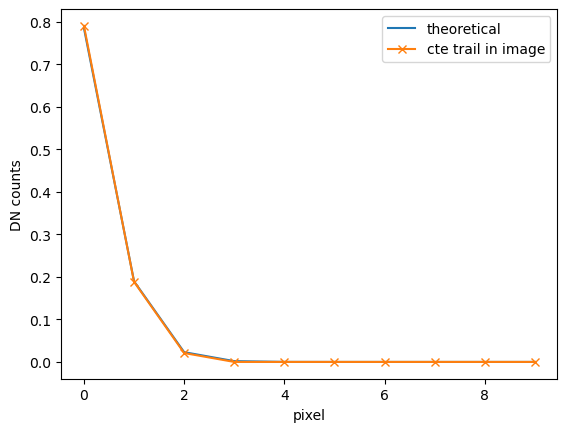

In [20]:
plt.plot(emccd.cti_trail, label='theoretical')
cic_row = cici[514, 536:546].astype(float)  - emccd.bias_level
plt.plot(cic_row/cic_row.sum(), '-x', label='cte trail in image')

plt.xlabel('pixel')
plt.ylabel('DN counts')
plt.legend()

下面的例子中，我们读取一幅之前生成的焦面图像，使用emccd类可以获得相机读出后的图像。

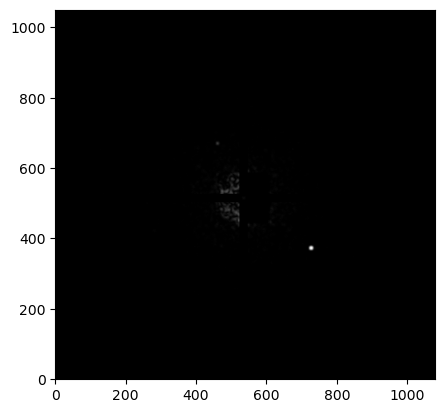

In [25]:
# 生成科学观测图像
area = 100 ** 2 * 3.14
focal_img = fits.getdata('image_files/focal_img.fits') * area

camera_output = emccd.readout(focal_img, 200, 20)

psf_imshow(camera_output, vmin=0, vmax=1)

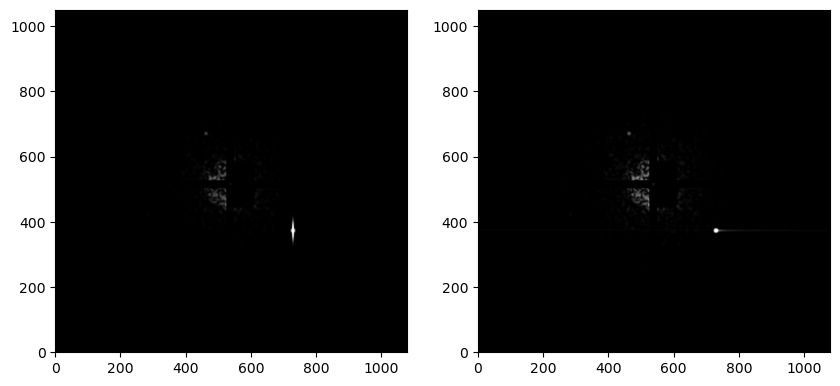

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
camera_output = emccd.readout(focal_img, 1, 2000, emgain=1)
psf_imshow(camera_output, vmin=0, vmax=1)

plt.subplot(1,2,2)
camera_output = emccd.readout(focal_img, 100, 200, emgain=100)
psf_imshow(camera_output, vmin=0, vmax=1)

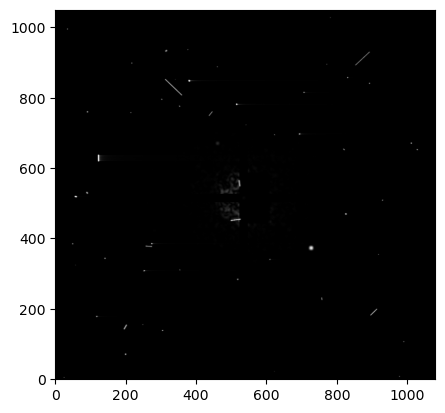

In [27]:
cr_frame = fits.getdata('image_files/cr_frame_30s.fit')
camera_output = emccd.readout(focal_img, 200, 30, image_cosmic_ray=cr_frame, emgain=200)
psf_imshow(camera_output, vmin=0, vmax=1)